In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pylab as plt
rng = np.random.default_rng(1)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [2]:
n = 15  # Problem dimensions
max_iter = 30  # Maximum number of iterations
n_init = 15  # Number of initial points
eps = 1e-03  # Tolerance

In [3]:
# Generate problem data
P = rng.standard_normal((n, n))
P = P + P.T  # Symmetrize
q = rng.standard_normal((n, 1))

In [4]:
# Compute bound using lagrange duality

lam = cp.Variable(n)

# Write matrix fraction q' * (P + lamb I)^{-1} q with Schur complement
m = P.shape[1]
T = cp.Variable((1, 1), symmetric=True)
M = cp.bmat([[P + cp.diag(lam), q],
             [q.T, T]])
objective = -0.5 * cp.trace(T) + cp.sum(lam)
problem = cp.Problem(cp.Maximize(objective), [lam >= 0])
problem.solve()
lower_bound = problem.value

In [5]:
# Solve SCP
q = q.flatten()
f_vals = np.zeros((n_init, max_iter))
for i in range(n_init):
    # Chose random starting point
    x_k = 2 * (rng.random(n) - 0.5)

    for k in range(max_iter):
        f_k = 0.5 * x_k.T @ P @ x_k + q @ x_k

        # Convexify objective
        D, V = np.linalg.eig(P)
        P_psd = V @ np.diag(np.maximum(D, 0)) @ V.T

        # Solve convexified problem
        x = cp.Variable(n)
        objective = f_k + (P @ x_k + q).T @ (x - x_k) + \
                0.5 * cp.quad_form(x - x_k, P_psd)
        constraints = [cp.norm(x, np.inf) <= 1]
        problem = cp.Problem(cp.Minimize(objective), constraints)
        problem.solve()
        f_vals[i, k] = problem.value

        # break if the relative progress is less than eps
        if np.linalg.norm(x.value - x_k) <= eps * np.linalg.norm(x_k):
            f_vals[i, k + 1:] = problem.value
            break

        x_k = x.value

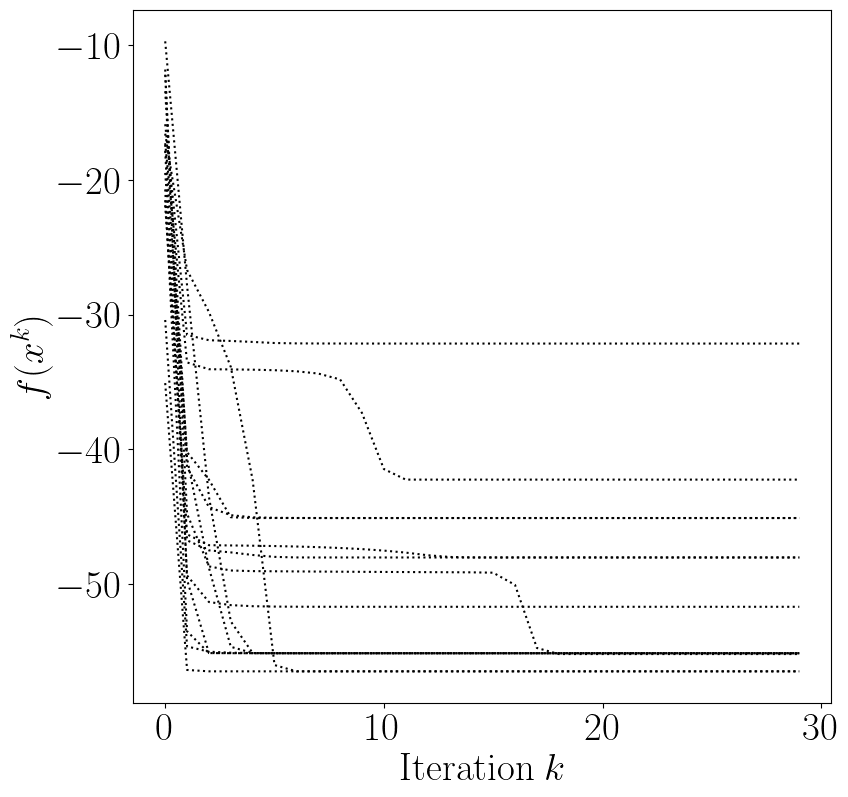

In [6]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(f_vals.T, color="k", linestyle="dotted")
ax.hlines(y=lower_bound, xmin=0, xmax=max_iter, linestyle="-", color="k")
ax.set_xlabel(r"${\rm Iteration}\; k$")
ax.set_ylabel(r"$f(x^k)$")
plt.savefig("nonconvex_qp.pdf")